# Word2Vec

Try gensim

After trying time series data, another common series data source is words, e.g. sentences.

In NLP, usually words are replaced by numbers indicating their frequency in a certain document. But doing this loses information regarding word relationship.

Two approaches: 

- Count-based: Compute statistics of how often a word co-occurs with its neighbor and mapping them to a small dense vector for each word.  
- Predictive based: Try to predict words by its neighbors by using small dense embedding vectors.

The goal of word2vec is to learn word embeddings by modeling each word as a vector in n-dimensional space.

Instead of just counting appearances, word2vec creates vector spaced models that represent (embed) word information in a continous vector space. (from the word "cat" the embedding could contain information regarding "animal", "pet", "four-legs", etc.)

Vector mathematics can be applied to these vectors. 

According to the prediction target, word2vec models can be: 

- Skip-gram: **the dog chews the** bone (better for large datasets)
- Continous Bag of Words (CBOW): the dog chews the **bone** (better for small datasets) It smoothes the distributed information by treating the context as one observation.

### CBOW

Noise Contrastive Training - contrasting the noise versus the actual target word. The train bases in a loss function that combines the probability of having a word in a context plus the probability of having one of *k* words, chosen as noise, in the same context.

To visualize relationships for each word vector, use `t-Distributed Stochastic Neighbor Embedding` for dimension reduction.



In [1]:
import collections
import math
import os
import errno
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

In [2]:
data_dir = "./04-Recurrent-Neural-Networks/word2vec_data/words"
data_url = "http://mattmahoney.net/dc/text8.zip"

In [4]:
def fetch_words_data(url=data_url, words_data=data_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok = True)
    
    # Path to zip file
    zip_path = os.path.join(words_data, "words.zip")
    
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
        
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [5]:
words = fetch_words_data()

In [6]:
len(words)

17005207

In [7]:
words[9000:9040]

['feelings',
 'and',
 'the',
 'auditory',
 'system',
 'of',
 'a',
 'person',
 'without',
 'autism',
 'often',
 'cannot',
 'sense',
 'the',
 'fluctuations',
 'what',
 'seems',
 'to',
 'non',
 'autistic',
 'people',
 'like',
 'a',
 'high',
 'pitched',
 'sing',
 'song',
 'or',
 'flat',
 'robot',
 'like',
 'voice',
 'is',
 'common',
 'in',
 'autistic',
 'children',
 'some',
 'autistic',
 'children']

In [8]:
for w in words[9000:9040]:
    print(w, end=' ')

feelings and the auditory system of a person without autism often cannot sense the fluctuations what seems to non autistic people like a high pitched sing song or flat robot like voice is common in autistic children some autistic children 

In [9]:
from collections import Counter

In [10]:
my_list = ["one", "two", "two"]

In [15]:
Counter(my_list).most_common(2)

[('two', 2), ('one', 1)]

In [16]:
def create_counts(vocab_size=50000):
    vocab = [] + Counter(words).most_common(vocab_size)
    vocab = np.array([word for word, _ in vocab])
    dictionary = { word: code for code, word in enumerate(vocab) }
    data = np.array([ dictionary.get(word, 0) for word in words])
    return data, vocab

In [17]:
data, vocabulary = create_counts()

In [20]:
data.shape

(17005207,)

In [22]:
vocabulary.shape

(50000,)

In [23]:
words[100]

'interpretations'

In [24]:
data[100]

4192

In [79]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [87]:
generate_batch(batch_size=4, num_skips=2, skip_window=4)

(array([3551, 3551,    0,    0], dtype=int32), array([[3551],
        [ 510],
        [3551],
        [   0]], dtype=int32))

In [89]:
vocabulary[3551]

'cavalry'

In [91]:
vocabulary[0]


'the'

In [92]:
vocabulary[510]

'included'

In [26]:
# CONSTANTS

In [27]:
batch_size = 128
embedding_size = 150
skip_window = 1
num_skips = 2 # How many times to reuse an input to generate a label

In [28]:
valid_size = 16 # Random set of words to evaluate similarity on

In [30]:
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [31]:
num_sampled = 64

In [32]:
learning_rate = 0.01

In [33]:
vocabulary_size = 50000

In [34]:
tf.reset_default_graph()

In [35]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [36]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [37]:
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)

In [38]:
embeddings = tf.Variable(init_embeds)

In [39]:
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [40]:
nce_weights = tf.Variable(
    tf.truncated_normal(
        [vocabulary_size, embedding_size],
        stddev=1.0/np.sqrt(embedding_size)
    )
)

In [42]:
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [43]:
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

In [44]:
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [45]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [46]:
data_index = 0

In [47]:
init = tf.global_variables_initializer()

In [49]:
num_steps = 5000
with tf.Session() as sess:
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {
            train_inputs: batch_inputs, 
            train_labels: batch_labels
        }
        _, loss_val = sess.run([trainer, loss], feed_dict = feed_dict)
        
        average_loss += loss_val
        
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss/1000
            print("Average loss at step ", step, " is: ", average_loss)
            average_loss = 0
            
        final_embeddings = normalized_embeddings.eval()

Average loss at step  0  is:  316.466583252
Average loss at step  1000  is:  9943.65548535
Average loss at step  2000  is:  16432.1750596
Average loss at step  3000  is:  19960.4611497
Average loss at step  4000  is:  19918.5276672


In [50]:
final_embeddings.shape

(50000, 150)

In [52]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [53]:
plot_only = 500

In [54]:
low_dim_embed = tsne.fit_transform(final_embeddings[:plot_only,:])

In [55]:
labels = [ vocabulary[i] for i in range(plot_only) ]

In [57]:
low_dim_embed.shape

(500, 2)

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )

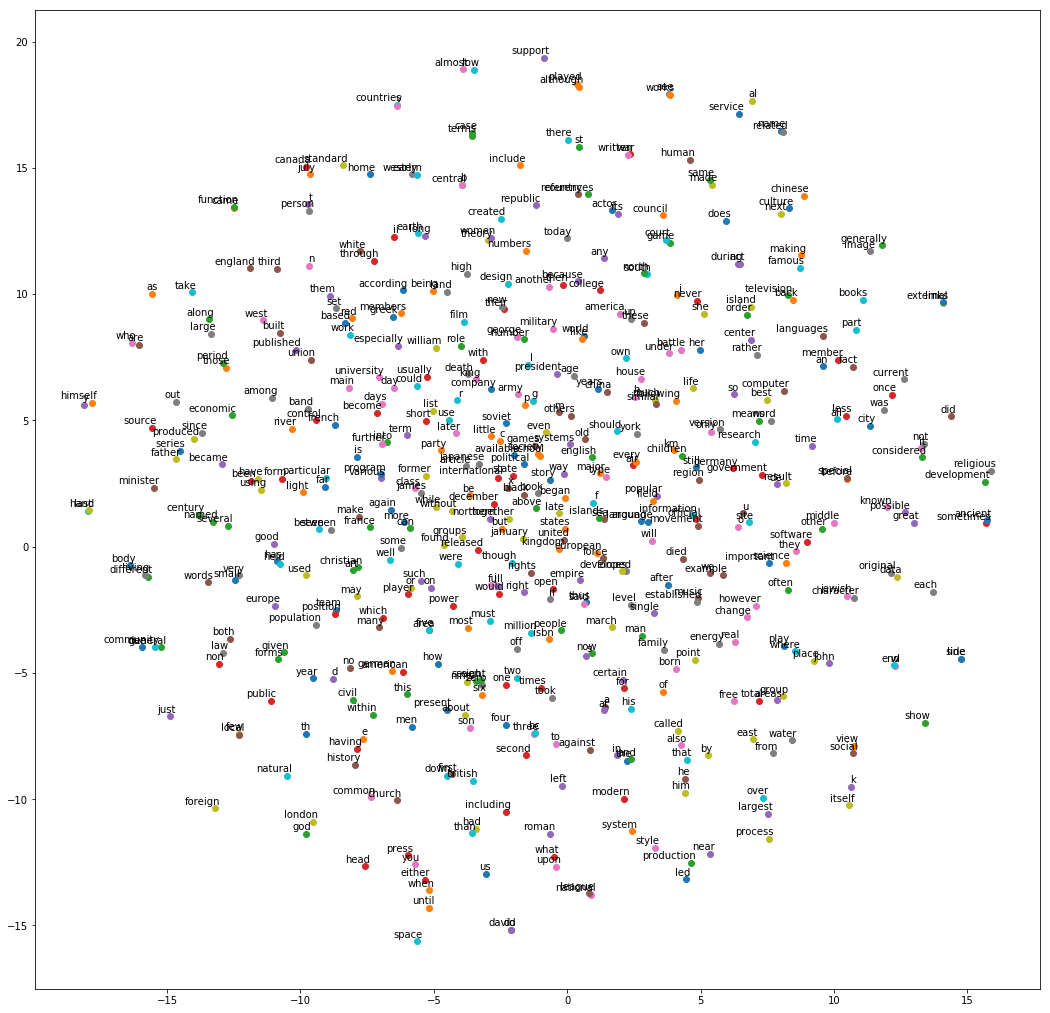

In [62]:
plot_with_labels(low_dim_embed, labels)

In [63]:
final_embeddings_200k = np.load("./04-Recurrent-Neural-Networks/trained_embeddings_200k_steps.npy")

In [68]:
final_embeddings_200k.shape

(50000, 150)

In [70]:
import time

In [72]:
t0 = time.time()
t1 = time.time()
print("Execution time: ", t1 - t0)

Execution time:  3.1948089599609375e-05


Size:  (1000, 2)
Fit transform time:  82.83529996871948
Plot time:  3.950827121734619


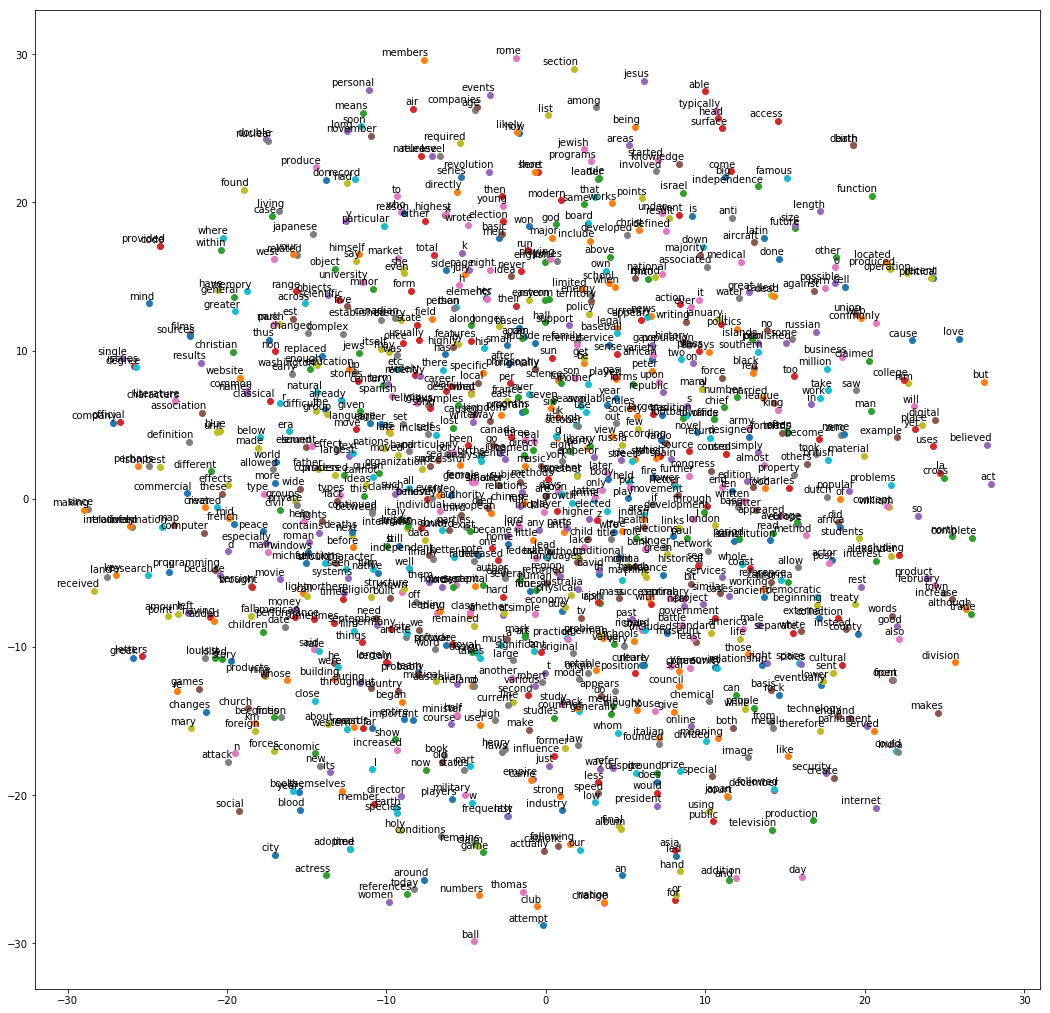

In [78]:
t0 = time.time()
plot_only = 1000
tsne_200k = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embed_200k = tsne.fit_transform(final_embeddings_200k[:plot_only,:])
labels = [ vocabulary[i] for i in range(plot_only) ]
t1 = time.time()
plot_with_labels(low_dim_embed_200k, labels)
t2 = time.time()
print("Size: ", low_dim_embed_200k.shape)
print("Fit transform time: ", t1 - t0)
print("Plot time: ", t2 - t1)

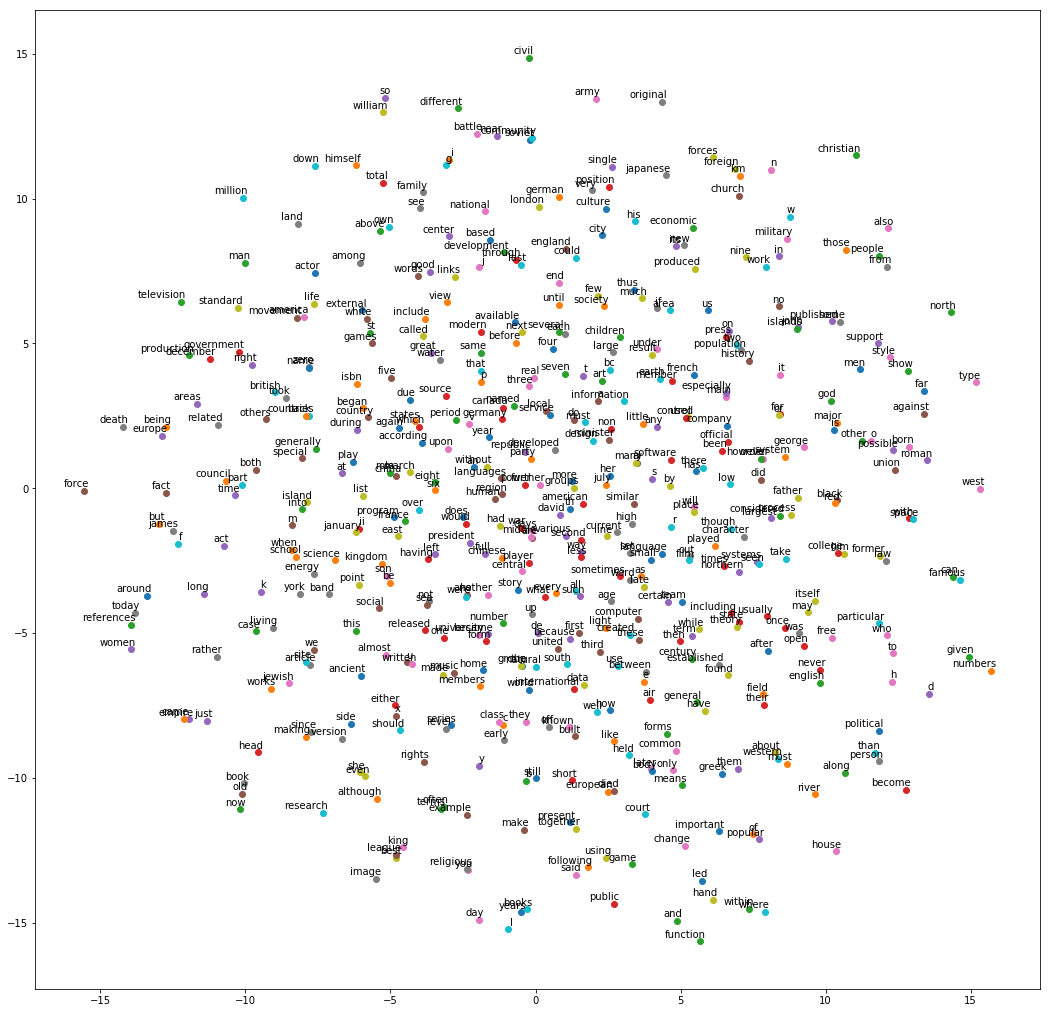